In [1]:
"""

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, measure
import cv2 as cv
import skimage as ski
import time
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import squidpy as sq
from numpy.random import default_rng
import scanpy as sc
import squidpy as sq
from anndata import AnnData
from statistics import mean
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import seaborn as sns
from pycirclize import Circos
from pycirclize.parser import Matrix
""";



In [2]:
# Read the image and segmentation mask
image = io.imread('../00_Data/PP_Images/R1B1ROI1/C-000_S-000_S_DAPI_R-01_W-B-1_ROI-01_A-DAPI.tif')
mask = io.imread('../02_Segmentation/FinalNucleiCytoSeg/R1B1ROI1_NucleiCytoSegmentationV2.tif')



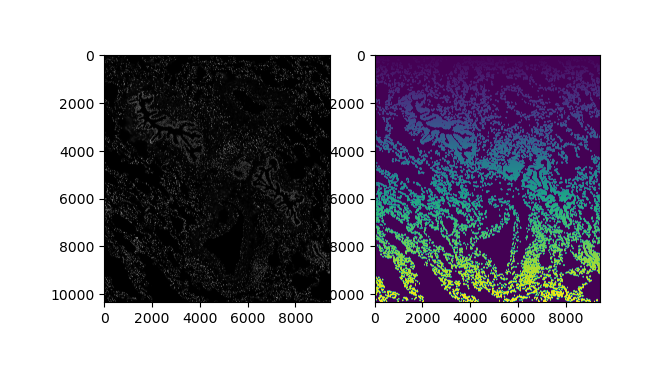

In [3]:
# visualising image and mask
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image, cmap="gray");
axarr[1].imshow(mask);

In [4]:
geo = pd.read_csv("../00_Data/CellShapeData/R1B1ROI1_Cellshape.csv")
geo_centroids = geo[["Cell Center X", "Cell Center Y"]]

In [5]:
properties = [ "area", "bbox", "centroid_local","convex_area","bbox_area", "extent",  
              "coords", "solidity", "eccentricity", 
              "orientation"]
segmentation_table = pd.DataFrame(regionprops_table(mask,
             properties=properties))

In [9]:
# Load in averages and celltypes data frames
averagesdf = pd.read_csv("averages_df.csv")
averagesdf = averagesdf.iloc[: , 1:] # drop first column, it's just the cell index
celltypesdf = pd.read_csv("celltypes_df.csv")

# Make into arrays
averages_array = averagesdf.to_numpy()
celltypes_array = celltypesdf["InferredCellType"].to_numpy()

In [10]:
# Get pixel centroids from table
def centroidnp(arr): # function works row-by-row to get centroid coords from coord pixel array
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    coords = sum_x/length, sum_y/length
    return np.asarray(coords)

# Apply to all rows in data frame
centroids = segmentation_table["coords"].apply(centroidnp)
centroids = np.vstack(centroids) # stack so that it's one numpy array

In [20]:
# For this instance, I want to remove "Other" and "Mixed" from this
indices_to_keep = (celltypes_array != "Other") & (celltypes_array != "Mixed")

filtered_centroids = centroids[indices_to_keep]
filtered_celltypes = celltypes_array[indices_to_keep]


In [32]:
filtered_centroids.shape
geo

,Cell Id,Cell Center X,Cell Center Y,Cell Shape Circle Like,Cell Shape Ellipse Like,Cell Shape Elongation,Cell Shape Square Like,Cell Shape Triangle Like,Cell Size,Nucleus Roundness
0,1@1,22.630121,9.151807,0.545862,1.000747,1.419526,0.785985,1.571970,830,1.000000
1,2@1,193.991119,20.964867,0.723134,1.061622,1.803011,0.833796,1.667592,2704,0.944895
2,3@1,305.498260,18.841869,0.604810,1.072163,1.685030,0.842075,1.684149,2890,1.000000
3,4@1,668.456360,17.406893,0.680903,0.858530,1.869170,0.674288,1.348576,1799,1.000000
4,5@1,2062.182861,15.165058,0.433621,0.867243,1.506356,0.681131,1.362262,2072,1.000000
...,...,...,...,...,...,...,...,...,...,...
11729,11730@1,8530.015625,10324.830078,0.423468,0.788121,1.545270,0.618988,1.237977,1493,1.000000
11730,11731@1,8992.842773,10326.298828,0.370491,0.804125,1.571412,0.631558,1.263116,1535,1.000000
11731,11732@1,5658.752930,10328.551758,0.341151,0.947161,1.514459,0.743899,1.487797,1088,1.000000
11732,11733@1,5723.349121,10320.030273,0.548933,1.097866,1.615256,0.862262,1.724523,2623,1.000000


In [21]:
# Function for computing distances between two cell types WITH CENTROIDS
def celltypes_distance(ct1, ct2, celltypes_array, centroids):
    # Getting cell indexes from cell types from celltypes_array
    ct1cells = np.where(celltypes_array == ct1)[0]
    ct2cells = np.where(celltypes_array == ct2)[0]
     
    # Making centroids arrays for the selected cells
    ct1coords = centroids[ct1cells]
    ct2coords = centroids[ct2cells]
 
    # Calculate distance matrix
    dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
    print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct2, dist_mat.shape[0], dist_mat.shape[1]))

    return(dist_mat)

dist_mat = celltypes_distance("T-cells", "T-cells", filtered_celltypes, filtered_centroids)

In the distance matrix for the cell types T-cells and T-cells, there are 0 rows and 0 columns.


In [17]:
dist_mat.shape

(231, 3074)

In [22]:
# Make this for all possible cell types combinations
### ?? What combinations do I want to do?

# Make all T-cell variants into the same
clean_celltypes_array = np.where(filtered_celltypes == "T-cells Mixed", "T-cells", filtered_celltypes)
clean_celltypes_array = np.where(clean_celltypes_array == "T-cells Naive", "T-cells", clean_celltypes_array)
clean_celltypes_array = np.where(clean_celltypes_array == "T-cells CD4+ (helper)", "T-cells", clean_celltypes_array)

cellTypes = np.unique(clean_celltypes_array)
full_dist_mat_tcells = {}


for ct2 in cellTypes:
    if ct2 == "T-cells":
        continue
        
    ct1 = "T-cells"
    dist_mat = celltypes_distance(ct1, ct2, clean_celltypes_array, filtered_centroids)
    full_dist_mat_tcells[ct2] = dist_mat.flatten()
    
#full_dist_mat_tcells = pd.DataFrame(full_dist_mat_tcells)
    

    


In the distance matrix for the cell types T-cells and Epithelial cells, there are 231 rows and 685 columns.
In the distance matrix for the cell types T-cells and Extracellular matrix, there are 231 rows and 1404 columns.
In the distance matrix for the cell types T-cells and Lymphatic vessel, there are 231 rows and 197 columns.
In the distance matrix for the cell types T-cells and Myocytes, there are 231 rows and 3074 columns.


<Axes: >

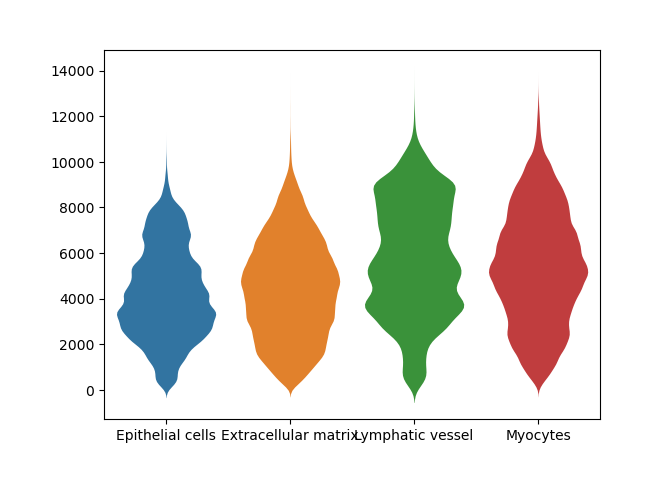

In [23]:
sns.violinplot(data=full_dist_mat_tcells)

In [46]:
# Distance Matrix function

# Function for computing distances between two cell types WITH CENTROIDS
def celltypes_distance_matrix_func(ct1, ct2, celltypes_array, centroids, pool_tcells=False, include_mixed=True, include_other=True):

    cellt = celltypes_array
    centr = centroids
    
    if include_mixed == False:
        indices_to_keep =(cellt != "Mixed")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if include_other == False:
        indices_to_keep =(cellt != "Other")
        centr = centr[indices_to_keep]
        cellt = cellt[indices_to_keep]
        
    if pool_tcells == True: # Make all T-cell variants into the same
        cellt = np.where(cellt == "T-cells Mixed", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Naive", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells CD4+ (helper)", "T-cells", cellt)
        cellt = np.where(cellt == "T-cells Memory", "T-cells", cellt)
        
        
    if len(ct2) == 1:
        # Getting cell indexes from cell types from celltypes_array
        ct1cells = np.where(cellt == ct1)[0]
        ct2cells = np.where(cellt == ct2[0])[0]

        # Making centroids arrays for the selected cells
        ct1coords = centr[ct1cells]
        ct2coords = centr[ct2cells]

        # Calculate distance matrix
        dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
        print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct2[0], dist_mat.shape[0], dist_mat.shape[1]))
    
        return(dist_mat.flatten())

    else:
        multiple_dist_mat = {}
        
        for ct in ct2:
            # Getting cell indexes from cell types from celltypes_array
            ct1cells = np.where(cellt == ct1)[0]
            ct2cells = np.where(cellt == ct)[0]

            # Making centroids arrays for the selected cells
            ct1coords = centr[ct1cells]
            ct2coords = centr[ct2cells]

            # Calculate distance matrix
            dist_mat = distance_matrix(ct1coords, ct2coords, p=2)
            print("In the distance matrix for the cell types {} and {}, there are {} rows and {} columns.".format(ct1, ct, dist_mat.shape[0], dist_mat.shape[1]))
            multiple_dist_mat[ct] = dist_mat.flatten()
        
        return(multiple_dist_mat)

dist_mat = celltypes_distance_matrix_func("T-cells Naive", ["T-cells Mixed", "T-cells Memory", "T-cells CD4+ (helper)"], celltypes_array, centroids, pool_tcells=False)




In the distance matrix for the cell types T-cells Naive and T-cells Mixed, there are 9 rows and 215 columns.
In the distance matrix for the cell types T-cells Naive and T-cells Memory, there are 9 rows and 0 columns.
In the distance matrix for the cell types T-cells Naive and T-cells CD4+ (helper), there are 9 rows and 7 columns.


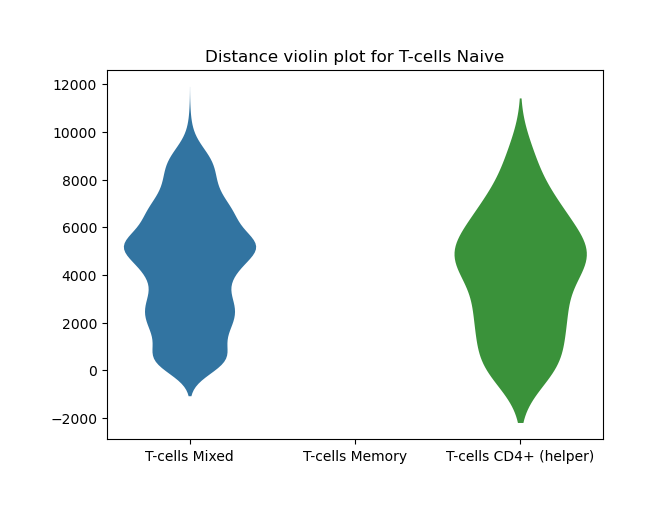

In [47]:
ax = sns.violinplot(data=dist_mat);
ax.set_title('Distance violin plot for T-cells Naive');

### Chord diagram

In [315]:
# Create from-to-table like in the example above

# How big should the radius of cells be? If all cells, put None
radius = 1

cellTypes = np.unique(celltypes_array)

## Add numbers of cells to data frame
# Create t cells df to loop through
tcellsindices = (celltypes_array == "T-cells") | (celltypes_array == "T-cells Mixed") | (celltypes_array == "T-cells Naive") | (celltypes_array == "T-cells CD4+ (helper)")
tcellscentroids = centroids[tcellsindices]
tcellscelltypes = celltypes_array[tcellsindices]
# Create all other cell types dfs
nottcellscentroids = centroids[~tcellsindices]
nottcellscelltypes = celltypes_array[~tcellsindices]

def create_fromtotable(fromcentroids, tocentroids, radius, cellTypes, fromcelltypes, tocelltypes):
    
    # Initialise data frame with combinations of cell types as columns
    combi = []
    for i in cellTypes:
        for j in cellTypes:
            if i != j:
                combi.append([i, j, 0])
    fromto_df = pd.DataFrame(combi, columns=["From", "To", "Amount"])

    # Loop through and calculate distances
    for idx in range(len(fromcentroids)):
        # Calculate distance matrix from this cell idx to all other cells
        cell = fromcentroids[idx] # Cell coordinates
        distances = np.linalg.norm(tocentroids - cell, axis=1) # Np array with all distances for "cell"

        if radius != None:
            distance_idxs = distances.argsort()[:radius] # indexes of closest ones within radius
            distances = distances[distance_idxs] # centroids of closest ones within radius
            selection_celltypes = tocelltypes[distance_idxs]

       
        # Find lowest average distance celltype for this specific cell
        averages_distances = [] # Initialise empty dict for averages
        for ct in cellTypes:
            #print(len(distances), len(selection_celltypes))
            ctdistances = distances[(selection_celltypes == ct)] # for T cells celltype, the ctdistances will be empty
            if len(ctdistances) != 0:
                averages_distances.append(mean(ctdistances))
            else:
                averages_distances.append(-1)

        # Add indication about neareset (lowest dist) celltype for this cell to fromto_df
        closest = averages_distances.index(min([i for i in averages_distances if i >= 0]))
        fromtype = fromcelltypes[idx]
        totype = cellTypes[closest]
        #print(fromtype, totype)
        fromto_df.loc[(fromto_df["From"] == fromtype) & (fromto_df["To"] == totype), "Amount"] += 1
        
    return(fromto_df)
        
fromto_df = create_fromtotable(tcellscentroids, nottcellscentroids, radius, cellTypes, tcellscelltypes, nottcellscelltypes)
   



In [314]:
cellTypes


array(['Epithelial cells', 'Extracellular matrix', 'Lymphatic vessel',
       'Mixed', 'Myocytes', 'Other', 'T-cells CD4+ (helper)',
       'T-cells Mixed', 'T-cells Naive'], dtype=object)

In [316]:
fromto_df

,From,To,Amount
0,Epithelial cells,Extracellular matrix,0
1,Epithelial cells,Lymphatic vessel,0
2,Epithelial cells,Mixed,0
3,Epithelial cells,Myocytes,0
4,Epithelial cells,Other,0
...,...,...,...
67,T-cells Naive,Mixed,4
68,T-cells Naive,Myocytes,1
69,T-cells Naive,Other,4
70,T-cells Naive,T-cells CD4+ (helper),0


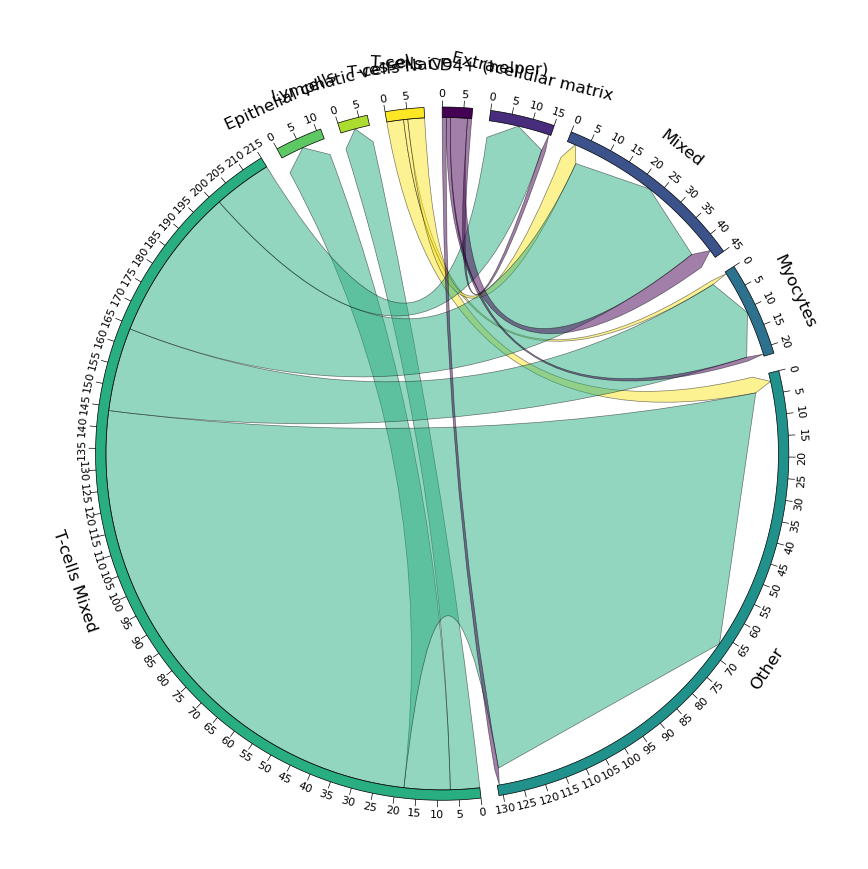

In [319]:
# Make diagram
matrix = Matrix.parse_fromto_table(fromto_df)

mycircos = Circos.initialize_from_matrix(
    matrix,
    space=3,
    cmap="viridis",
    ticks_interval=5,
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

#print(fromto_df.to_string(index=False))
fig = mycircos.plotfig()


In [153]:
fromto_df

,From,To,Amount
0,Epithelial cells,Extracellular matrix,0
1,Epithelial cells,Lymphatic vessel,0
2,Epithelial cells,Mixed,0
3,Epithelial cells,Myocytes,0
4,Epithelial cells,Other,0
...,...,...,...
85,T-cells mixed,Myocytes,0
86,T-cells mixed,Other,5
87,T-cells mixed,T-cells,0
88,T-cells mixed,T-cells CD4+ (helper),0


In [16]:
print(fromto_df.loc[(fromto_df["From"] == "T-cells Naive")])

             From                     To  Amount
72  T-cells Naive       Epithelial cells       6
73  T-cells Naive   Extracellular matrix       0
74  T-cells Naive       Lymphatic vessel       0
75  T-cells Naive                  Mixed       0
76  T-cells Naive               Myocytes       0
77  T-cells Naive                  Other       4
78  T-cells Naive                T-cells       0
79  T-cells Naive  T-cells CD4+ (helper)       0
80  T-cells Naive          T-cells mixed       0


In [1]:
import plotly.graph_objects as go

# Making df for sankey diagram
sankeydf = fromto_df.copy()
type_index_map = {cell_type: index for index, cell_type in enumerate(cellTypes)}
sankeydf["From"] = sankeydf["From"].replace(type_index_map)
sankeydf["To"] = sankeydf["To"].replace(type_index_map)
#sankeydf["FromLabel"] = fromto_df["From"]
#sankeydf["ToLabel"] = fromto_df["To"]
cols = ['grey',
        'grey',
        'grey',
        'grey',
        'grey',
        'grey',
        'rgba(148, 103, 189, 0.8)',
        'rgba(44, 160, 44, 0.8)',
        'rgba(31, 119, 180, 0.8)',
        'rgba(23, 190, 207, 0.8)'] 
col_index_map = {index: col for index, col in enumerate(cols)}
col_index_map_opaque = {k: v.replace('0.8', '0.4') for k, v in col_index_map.items()}
sankeydf["Colours"] = sankeydf["From"].replace(col_index_map_opaque)


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = cellTypes,
      color = cols
    ),
    link = dict(
      source = sankeydf["From"], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = sankeydf["To"],
      value = sankeydf["Amount"],
      color = sankeydf["Colours"]
  ))])

fig.update_layout(title_text="Distance Sankey diagram", font_size=10)  
fig.show()

NameError: name 'fromto_df' is not defined

In [300]:
np.unique(celltypes_array)

array(['Epithelial cells', 'Extracellular matrix', 'Lymphatic vessel',
       'Mixed', 'Myocytes', 'Other', 'T-cells', 'T-cells CD4+ (helper)',
       'T-cells Naive', 'T-cells mixed'], dtype=object)